In [137]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [138]:
test_unknown_data_path = './data/3_rf_test_unknown_data_v2.csv'
test_unknown_data = pd.read_csv(test_unknown_data_path)

test_unknown_label_path = './data/3_rf_test_unknown_label_v2.csv'
test_unknown_label = pd.read_csv(test_unknown_label_path)

In [139]:
import pickle

In [140]:
with open('./data/5_gan_data_v1_1.pkl', 'rb') as file:
    gan_data_v1 = pickle.load(file)
with open('./data/5_gan_label_v1_1.pkl', 'rb') as file:
    gan_label_v1 = pickle.load(file)
with open('./data/5_gan_data_v1_2.pkl', 'rb') as file:
    gan_data_v1a = pickle.load(file)
with open('./data/5_gan_label_v1_2.pkl', 'rb') as file:
    gan_label_v1a = pickle.load(file)

In [141]:
with open('./data/5_gan_data_v2_1.pkl', 'rb') as file:
    gan_data_v2 = pickle.load(file)
with open('./data/5_gan_label_v2_1.pkl', 'rb') as file:
    gan_label_v2 = pickle.load(file)
with open('./data/5_gan_data_v2_2.pkl', 'rb') as file:
    gan_data_v2a = pickle.load(file)
with open('./data/5_gan_label_v2_2.pkl', 'rb') as file:
    gan_label_v2a = pickle.load(file)

In [142]:
with open('./data/class_mapping.pkl', 'rb') as file:
    class_mapping = pickle.load(file)

In [143]:
class_mapping

{'Backdoor_Malware': 0,
 'BenignTraffic': 1,
 'BrowserHijacking': 2,
 'CommandInjection': 3,
 'DDoS-ACK_Fragmentation': 4,
 'DDoS-HTTP_Flood': 5,
 'DDoS-ICMP_Flood': 6,
 'DDoS-ICMP_Fragmentation': 7,
 'DDoS-PSHACK_Flood': 8,
 'DDoS-RSTFINFlood': 9,
 'DDoS-SYN_Flood': 10,
 'DDoS-SlowLoris': 11,
 'DDoS-SynonymousIP_Flood': 12,
 'DDoS-TCP_Flood': 13,
 'DDoS-UDP_Flood': 14,
 'DDoS-UDP_Fragmentation': 15,
 'DNS_Spoofing': 16,
 'DictionaryBruteForce': 17,
 'DoS-HTTP_Flood': 18,
 'DoS-SYN_Flood': 19,
 'DoS-TCP_Flood': 20,
 'DoS-UDP_Flood': 21,
 'MITM-ArpSpoofing': 22,
 'Mirai-greeth_flood': 23,
 'Mirai-greip_flood': 24,
 'Mirai-udpplain': 25,
 'Recon-HostDiscovery': 26,
 'Recon-OSScan': 27,
 'Recon-PingSweep': 28,
 'Recon-PortScan': 29,
 'SqlInjection': 30,
 'Uploading_Attack': 31,
 'VulnerabilityScan': 32,
 'XSS': 33}

In [144]:
# flip the dictionary. key into value, and vice versa
flipped_dict = dict((v, k) for k, v in class_mapping.items())

In [145]:
gan_label_v1 = pd.DataFrame(gan_label_v1)
gan_label_v2 = pd.DataFrame(gan_label_v2)
gan_label_v1a = pd.DataFrame(gan_label_v1)
gan_label_v2a = pd.DataFrame(gan_label_v2)

In [146]:
gan_label_v1

,label
0,1
1,1
2,1
3,1
4,1
...,...
16872,8
16873,7
16874,7
16875,4


In [147]:
gan_label_v1['label'] = gan_label_v1['label'].replace(flipped_dict)
gan_label_v2['label'] = gan_label_v2['label'].replace(flipped_dict)
gan_label_v1a['label'] = gan_label_v1a['label'].replace(flipped_dict)
gan_label_v2a['label'] = gan_label_v2a['label'].replace(flipped_dict)

In [148]:
gan_label_v1['label'].value_counts()
gan_label_v1a['label'].value_counts()

label
BenignTraffic              15119
DDoS-PSHACK_Flood            768
DDoS-ICMP_Fragmentation      515
DDoS-ACK_Fragmentation       348
DDoS-HTTP_Flood               52
DDoS-RSTFINFlood              39
BrowserHijacking              12
CommandInjection               7
Backdoor_Malware               6
DDoS-SlowLoris                 6
DDoS-ICMP_Flood                5
Name: count, dtype: int64

In [149]:
attacks = ['DDoS', 'DoS', 'Mirai', 'Recon']

def mergeAttacks(dataframe, attacks):
    """ Merge attacks into big category

    Args:
        dataframe(Pandas dataframe): Contains specific attacks

    Return:
        (Pandas dataframe): merged dataframe
    """

    dataframe.loc[dataframe['label'].str.contains('DDoS'), 'label'] = 'andrew-nah'

    for attack in attacks:
        if attack == 'DDoS':
            continue
        dataframe.loc[dataframe['label'].str.contains(attack), 'label'] = attack
    
    dataframe.loc[dataframe['label'].str.contains('andrew-nah'), 'label'] = 'DDoS'
    
    return dataframe

# Merge attacks in syntesized data

In [150]:
gan_label_v1 = mergeAttacks(gan_label_v1, attacks)
gan_label_v2 = mergeAttacks(gan_label_v2, attacks)
gan_label_v1a = mergeAttacks(gan_label_v1a, attacks)
gan_label_v2a = mergeAttacks(gan_label_v2a, attacks)

# Drop the major attacks; DDoS, DoS, Mirai

In [151]:
def dropMajor(data, label):
    """ Drop the designated attacks

    Args:
        data(Pandas dataframe): data without labels
        label(Pandas dataframe): corresponding labels to data

    Return:
        (Pandas dataframe): dataframe without designated attacks

    """
    df = pd.concat([data, label], axis=1)
    df_filtered = df.drop(df[df['label'].isin(['BenignTraffic'])].index)
    return df_filtered


In [152]:
gan_dropped_v1 = dropMajor(gan_data_v1, gan_label_v1)
gan_dropped_v2 = dropMajor(gan_data_v2, gan_label_v2)
gan_dropped_v1a = dropMajor(gan_data_v1a, gan_label_v1a)
gan_dropped_v2a = dropMajor(gan_data_v2a, gan_label_v2a)

In [153]:
gan_dropped_v1['label'].value_counts()
gan_dropped_v1a['label'].value_counts()

label
DDoS                1733
BrowserHijacking      12
CommandInjection       7
Backdoor_Malware       6
Name: count, dtype: int64

In [154]:
gan_dropped_v2['label'].value_counts()
gan_dropped_v2a['label'].value_counts()

label
DDoS                593
BrowserHijacking      4
CommandInjection      4
Backdoor_Malware      2
Name: count, dtype: int64

In [155]:
gan_dropped_data_v1 = gan_dropped_v1.drop(columns=['label'])
gan_dropped_label_v1 = pd.DataFrame(gan_dropped_v1['label'])
gan_dropped_data_v2 = gan_dropped_v2.drop(columns=['label'])
gan_dropped_label_v2 = pd.DataFrame(gan_dropped_v2['label'])
gan_dropped_data_v1a = gan_dropped_v1a.drop(columns=['label'])
gan_dropped_label_v1a = pd.DataFrame(gan_dropped_v1a['label'])
gan_dropped_data_v2a = gan_dropped_v2a.drop(columns=['label'])
gan_dropped_label_v2a = pd.DataFrame(gan_dropped_v2a['label'])

# Merge original and synthesized data together

In [156]:
gan_merged_data = pd.concat([gan_dropped_data_v1,gan_dropped_data_v2], axis=0)
gan_merged_label = pd.concat([gan_dropped_label_v1, gan_dropped_label_v2], axis=0)
gan_merged_data2 = pd.concat([gan_dropped_data_v1a,gan_dropped_data_v2a], axis=0)
gan_merged_label2 = pd.concat([gan_dropped_label_v1a, gan_dropped_label_v2a], axis=0)
gan_data = pd.concat([gan_merged_data,gan_merged_data2], axis=0)
gan_label = pd.concat([gan_merged_label, gan_merged_label2], axis=0)
train_data = pd.concat([gan_data,test_unknown_data], axis=0)
train_label = pd.concat([gan_label, test_unknown_label], axis=0)

In [157]:
train_label.value_counts()

label               
BenignTraffic           5062
DDoS                    4652
Recon                    258
MITM-ArpSpoofing         191
DNS_Spoofing             135
BrowserHijacking          36
CommandInjection          25
DictionaryBruteForce      21
Backdoor_Malware          19
SqlInjection              11
XSS                        2
VulnerabilityScan          1
Name: count, dtype: int64

In [158]:
# Display column names
print("Column names:")
print(train_data.columns)

# Display dataset shape
print("\nDataset shape:")
print(train_data.shape)


Column names:
Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight'],
      dtype='object')

Dataset shape:
(10416, 46)


In [159]:
# Print data types
print("\nData Types:")
print(train_data.dtypes)


Data Types:
flow_duration      float64
Header_Length      float64
Protocol Type      float64
Duration           float64
Rate               float64
Srate              float64
Drate              float64
fin_flag_number    float64
syn_flag_number    float64
rst_flag_number    float64
psh_flag_number    float64
ack_flag_number    float64
ece_flag_number    float64
cwr_flag_number    float64
ack_count          float64
syn_count          float64
fin_count          float64
urg_count          float64
rst_count          float64
HTTP               float64
HTTPS              float64
DNS                float64
Telnet             float64
SMTP               float64
SSH                float64
IRC                float64
TCP                float64
UDP                float64
DHCP               float64
ARP                float64
ICMP               float64
IPv                float64
LLC                float64
Tot sum            float64
Min                float64
Max                float64
AVG            

c:\Users\aravi\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\aravi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


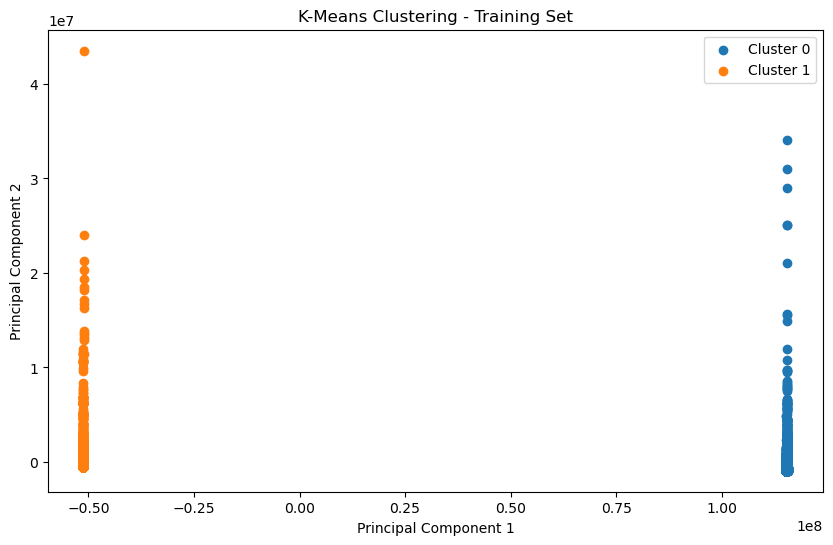

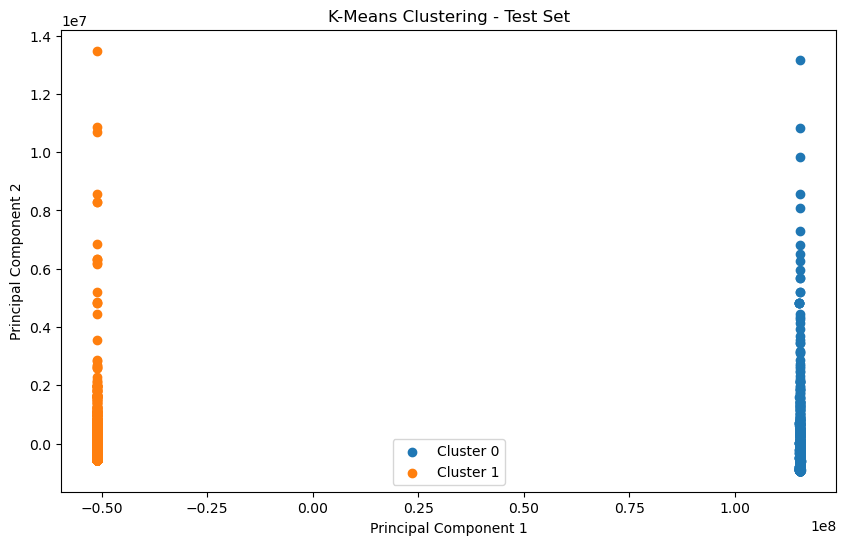

In [160]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import numpy as np

X = train_data
y = train_label

# Assuming your data is in X and ground truth labels are in y
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode the ground truth labels with handle_unknown='ignore'
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Specify the number of clusters
number_of_clusters = 2  # Adjust this based on your data

# Apply k-means clustering on the training set
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
train_predicted_labels = kmeans.fit_predict(X_train)

# Apply the clustering model to the test set
test_predicted_labels = kmeans.predict(X_test)

# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Scatter plot for training set
plt.figure(figsize=(10, 6))
for cluster in range(number_of_clusters):
    cluster_mask = (train_predicted_labels == cluster)
    plt.scatter(X_train_reduced[cluster_mask, 0], X_train_reduced[cluster_mask, 1], label=f'Cluster {cluster}')

plt.title('K-Means Clustering - Training Set')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Scatter plot for test set
plt.figure(figsize=(10, 6))
for cluster in range(number_of_clusters):
    cluster_mask = (test_predicted_labels == cluster)
    plt.scatter(X_test_reduced[cluster_mask, 0], X_test_reduced[cluster_mask, 1], label=f'Cluster {cluster}')

plt.title('K-Means Clustering - Test Set')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

c:\Users\aravi\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\aravi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


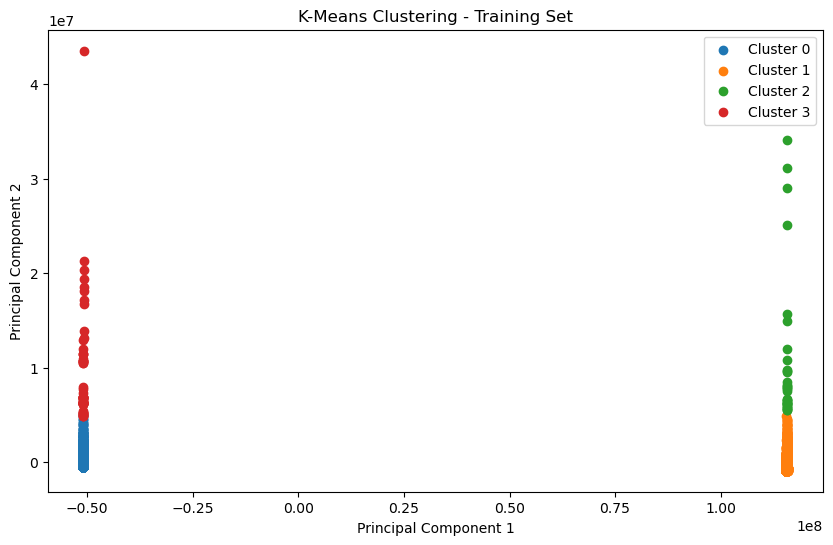

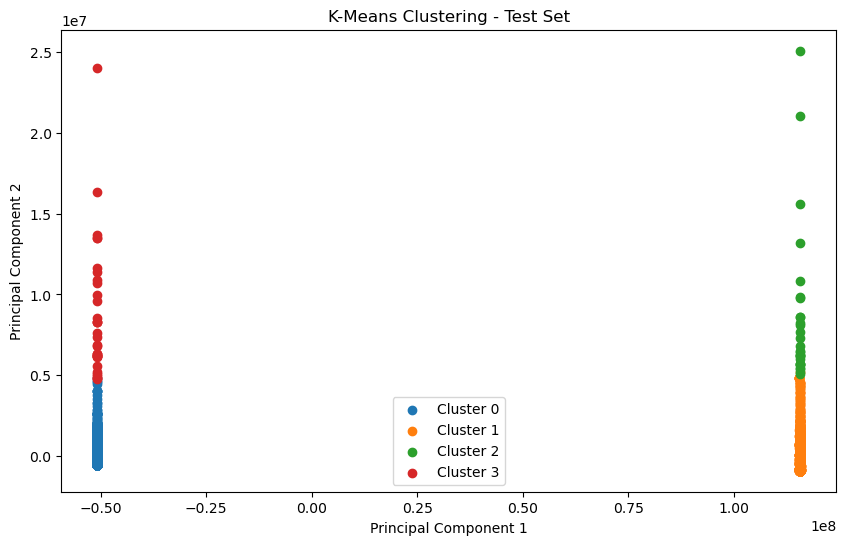

In [161]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np

X = train_data
y = train_label



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Encode the ground truth labels with handle_unknown='ignore'
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Specify the number of clusters
number_of_clusters = 4  # Adjust this based on your data

# Apply k-means clustering on the training set
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
train_predicted_labels = kmeans.fit_predict(X_train)

# Apply the clustering model to the test set
test_predicted_labels = kmeans.predict(X_test)

# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Scatter plot for training set
plt.figure(figsize=(10, 6))
for cluster in range(number_of_clusters):
    cluster_mask = (train_predicted_labels == cluster)
    plt.scatter(X_train_reduced[cluster_mask, 0], X_train_reduced[cluster_mask, 1], label=f'Cluster {cluster}')

plt.title('K-Means Clustering - Training Set')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Scatter plot for test set
plt.figure(figsize=(10, 6))
for cluster in range(number_of_clusters):
    cluster_mask = (test_predicted_labels == cluster)
    plt.scatter(X_test_reduced[cluster_mask, 0], X_test_reduced[cluster_mask, 1], label=f'Cluster {cluster}')

plt.title('K-Means Clustering - Test Set')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
